In [1]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp
import matplotlib as mpl
import xarray as xr
import time

from astropy.io import ascii
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq

# # Gala
# from gala.mpl_style import mpl_style
# plt.style.use(mpl_style)
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

import utils as ut
import plot_utils as pu

        Use @ instead. [gala.coordinates.sgr]
        Use @ instead. [gala.coordinates.orphan]
        Use @ instead. [gala.coordinates.magellanic_stream]


In [2]:
def get_potential(log_M_h, log_r_s, log_M_n, log_a):
    mw_potential = gp.CCompositePotential()
    mw_potential['bulge'] = gp.HernquistPotential(m=5E9, c=1., units=galactic)
    mw_potential['disk'] = gp.MiyamotoNagaiPotential(m=6.8E10*u.Msun, a=3*u.kpc, b=280*u.pc,
                                                     units=galactic)
    mw_potential['nucl'] = gp.HernquistPotential(m=np.exp(log_M_n), c=np.exp(log_a)*u.pc,
                                                 units=galactic)
    mw_potential['halo'] = gp.NFWPotential(m=np.exp(log_M_h), r_s=np.exp(log_r_s), units=galactic)

    return mw_potential

x0 = [np.log(6E11), np.log(20.), np.log(2E9), np.log(100.)]
mw_potential = get_potential(*x0)

In [4]:
components = ['bulge', 'disk', 'nucl', 'halo']

for comp in components:
    print(comp)
    print('Latex')
    print(mw_potential[comp].parameters)
    print(mw_potential[comp].to_latex())
    print('Sympy')
    print(mw_potential[comp].to_sympy())
    print('\n')

bulge
Latex
{'m': <Quantity 5.e+09 solMass>, 'c': <Quantity 1. kpc>}
- \frac{G m}{c + \sqrt{x^{2} + y^{2} + z^{2}}}
Sympy
(-G*m/(c + sqrt(x**2 + y**2 + z**2)), {'x': x, 'y': y, 'z': z}, {'m': m, 'c': c, 'G': G})


disk
Latex
{'m': <Quantity 6.8e+10 solMass>, 'a': <Quantity 3. kpc>, 'b': <Quantity 0.28 kpc>}
- \frac{G m}{\sqrt{x^{2} + y^{2} + \left(a + \sqrt{b^{2} + z^{2}}\right)^{2}}}
Sympy
(-G*m/sqrt(x**2 + y**2 + (a + sqrt(b**2 + z**2))**2), {'x': x, 'y': y, 'z': z}, {'m': m, 'a': a, 'b': b, 'G': G})


nucl
Latex
{'m': <Quantity 2.e+09 solMass>, 'c': <Quantity 0.1 kpc>}
- \frac{G m}{c + \sqrt{x^{2} + y^{2} + z^{2}}}
Sympy
(-G*m/(c + sqrt(x**2 + y**2 + z**2)), {'x': x, 'y': y, 'z': z}, {'m': m, 'c': c, 'G': G})


halo
Latex
{'m': <Quantity 6.e+11 solMass>, 'r_s': <Quantity 20. kpc>, 'a': <Quantity 1.>, 'b': <Quantity 1.>, 'c': <Quantity 1.>}
- \frac{G m \log{\left(1 + \frac{\sqrt{\frac{z^{2}}{c^{2}} + \frac{y^{2}}{b^{2}} + \frac{x^{2}}{a^{2}}}}{r_{s}} \right)}}{\sqrt{\frac{z^{2}}{c^{2

We define the sympy expressions

In [5]:
x, y, z, G = sp.symbols('x y z G')

m_B, c_B = sp.symbols('m_B c_B')
bulge_pot = -G*m_B/(c_B + sp.sqrt(x**2 + y**2 + z**2))

m_D, a_D, b_D = sp.symbols('m_D a_D b_D')
disk_pot = -G*m_D/sp.sqrt(x**2 + y**2 + (a_D + sp.sqrt(b_D**2 + z**2))**2)

m_N, c_N = sp.symbols('m_N c_N')
nucl_pot = -G*m_N/(c_N + sp.sqrt(x**2 + y**2 + z**2))

m_H, r_H, a_H, b_H, c_H = sp.symbols('m_H r_H a_H b_H c_H')
halo_pot = -G*m_H*sp.log(1 + sp.sqrt(z**2/c_H**2 + y**2/b_H**2 + x**2/a_H**2)/r_H)/sp.sqrt(z**2/c_H**2 + y**2/b_H**2 + x**2/a_H**2)


def laplacian(pot, symbols=(x, y, z), simplify=True):
    lap = sum(sp.diff(sp.diff(pot, sym), sym) for sym in symbols)
    return lap.simplify() if simplify else lap
def density(pot, symbols=(x, y, z), simplify=True):
    dens = laplacian(pot, symbols=symbols, simplify=simplify)/(4*sp.pi*G) 
    return dens.simplify() if simplify else dens   

bulge_dens = density(bulge_pot, symbols=(x, y, z))
disk_dens = density(disk_pot, symbols=(x, y, z))
nucl_dens = density(nucl_pot, symbols=(x, y, z))
halo_dens = density(halo_pot, symbols=(x, y, z), simplify=False)

bulge_dens_func = sp.lambdify((x, y, z, c_B, m_B), bulge_dens, 'numpy')
def bulge_density(x_val, y_val, z_val, c_B_val=1, m_B_val=5.e+09):
    return bulge_dens_func(x_val, y_val, z_val, c_B_val, m_B_val)
disk_dens_func = sp.lambdify((x, y, z, a_D, b_D, m_D), disk_dens, 'numpy')
def disk_density(x_val, y_val, z_val, a_D_val=3, b_D_val=0.28, m_D_val=6.8e+10):
    return disk_dens_func(x_val, y_val, z_val, a_D_val, b_D_val, m_D_val)
nucl_dens_func = sp.lambdify((x, y, z, c_N, m_N), nucl_dens, 'numpy')
def nucl_density(x_val, y_val, z_val, c_N_val=0.1, m_N_val=2e+09):
    return nucl_dens_func(x_val, y_val, z_val, c_N_val, m_N_val)
halo_dens_func = sp.lambdify((x, y, z, a_H, b_H, c_H, r_H, m_H), halo_dens, 'numpy')
def halo_density(x_val, y_val, z_val, a_H_val=1, b_H_val=1, c_H_val=1, r_H_val=20, m_H_val=6e+11):
    return halo_dens_func(x_val, y_val, z_val, a_H_val, b_H_val, c_H_val, r_H_val, m_H_val)

def eval_pots(x, y, z, 
              fs = (nucl_density, bulge_density, disk_density, halo_density),
              names = ('nucl', 'bulge', 'disk', 'halo'),
              log_bool=True):

    dic_vals = {}
    for f, name in zip(fs, names):
        dic_vals[name] = f(x, y, z).astype('float32')
    
    dic_vals['total'] = sum(dic_vals.values())
    if log_bool:
        for name in dic_vals.keys():
            dic_vals[name] = np.log10(dic_vals[name])
    return dic_vals


In [6]:
S = 200
xy_lim, z_lim = 10, 5
x_ = np.linspace(-xy_lim, xy_lim, S)
y_ = np.linspace(-xy_lim, xy_lim, S)
z_ = np.linspace(-z_lim, z_lim, S)

XY, YX = np.meshgrid(x_, y_, indexing='ij')
y_0 = 0
XZ, ZX = np.meshgrid(x_, z_, indexing='ij')
z_0 = 0

dens_xz = eval_pots(XZ, 0, ZX, log_bool=True)

nucl
bulge
disk
halo
total


C:\Users\Pere\AppData\Local\Temp\ipykernel_6656\3522275900.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap_color)
C:\Users\Pere\AppData\Local\Temp\ipykernel_6656\3522275900.py:50: UserWarning: The following kwargs were not used by contour: 'label'
  axs[0].contour(XZ, ZX, dens_xz[name], label=name, colors=colors_[i], levels=levels, linestyles='dashed', linewidths=lw*fs)


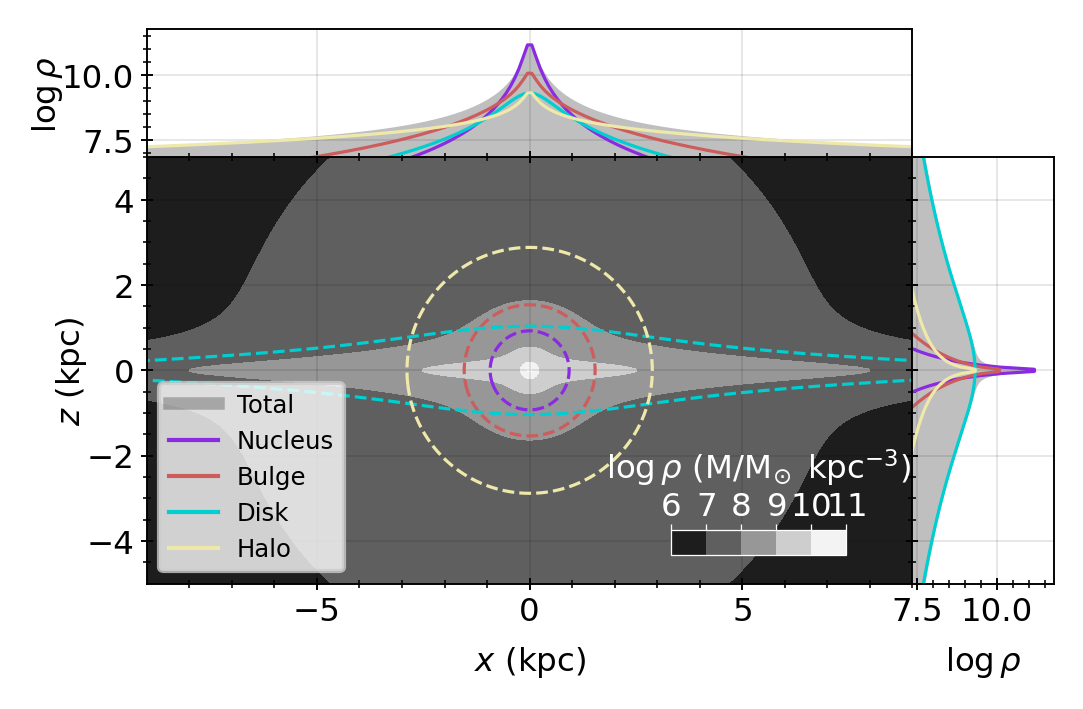

In [9]:
c = +0.01
rat = 0.3

xlim = 0.9*xy_lim
fig_size, ratio = 720, xlim/z_lim
lw, ts = 0.25, 2.55

fig, axs, fs = pu.image_and_profile_plot(fig_size=fig_size, ratio=ratio, c=c, rat=rat, ts=ts)

#axs[0].imshow(dens_xz['total'].T, extent=[-xlim, xlim, -z_lim, z_lim], cmap='Greys_r', alpha=1, zorder=1)
cflevels = [6,7,8,9,10,11]
cf_plot = axs[0].contourf(x_, z_, dens_xz['total'].T, extent=[-xlim, xlim, -z_lim, z_lim], cmap='Greys_r', alpha=1, zorder=1,
                levels=cflevels)
# make a cbar for this contourf and place it INSIDE the plot, horizontal on lower right

colorbar_axes = fig.add_axes([0.5725, 0.15, 0.15, 0.035])
cbar = fig.colorbar(cf_plot, cax=colorbar_axes, orientation='horizontal')
cbar.set_label('Value', rotation=0)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=ts*fs)
cbar.ax.xaxis.set_ticks(cflevels)
cbar.ax.xaxis.set_ticklabels([r'${%d}$'%i for i in cflevels])
cbar.ax.set_xlabel(r'$\log \rho$ (M/M$_{\!\odot}$ kpc$^{-3}$)', fontsize=fs*ts, labelpad=1*fs, color='w')
#change frame color
cbar.outline.set_edgecolor('w')
cbar.outline.set_linewidth(0.1*fs)

cbar.ax.tick_params(axis='x', colors='w', width=0.1*fs,
                    length=0.5*fs, pad=0.1*fs, labelsize=ts*fs)



levels = [7.5]
M = len(levels)
cmaps = ['Reds', 'YlOrBr_r', 'Blues', 'Purples', 'Greys']

colors_ = ['purple', (213/255, 94/255, 0), (86/255, 180/255, 233/255), (240/255, 228/255, 66/255)]
colors_ = ['blueviolet', 'indianred', 'darkturquoise', 'palegoldenrod']
for i, name in enumerate(dens_xz.keys()):
    print(name)
    if name != 'total':
        cmap_color = cmaps[i]
        cmap = mpl.cm.get_cmap(cmap_color)
        colors = [cmap(i) for i in np.linspace(0.7, 0.71, M)]
        color = cmap(0.71)
        color = colors_[i]
        axs[1].plot(x_, dens_xz[name][S//2], lw=fs*lw, color=color, zorder=2)
        axs[2].plot(dens_xz[name][:,S//2],z_, lw=fs*lw, color=color, zorder=2)
        axs[0].contour(XZ, ZX, dens_xz[name], label=name, colors=colors_[i], levels=levels, linestyles='dashed', linewidths=lw*fs)

alph = 0.25
axs[1].fill_between(x_, dens_xz['total'][S//2], label='total', color='k', alpha=alph, zorder=1, lw=0)
axs[1].set_xlim(-xlim, xlim)
axs[1].set_ylim(np.min(dens_xz['total'][S//2])*0.95, np.max(dens_xz['total'][S//2])*1.05)

# Fill plot for axs[2]
axs[2].fill_betweenx(z_, dens_xz['total'][:,S//2], label='total', color='k', alpha=alph, zorder=1, lw=0)
axs[2].set_xlim(np.min(dens_xz['total'][:,S//2])*0.95, np.max(dens_xz['total'][:,S//2])*1.05)
axs[2].set_ylim(-z_lim, z_lim)

lp = -0.25
axs[0].set_xlabel('$x$ (kpc)', fontsize=fs*ts)
axs[0].set_ylabel('$z$ (kpc)', fontsize=fs*ts, labelpad=lp*fs)

axs[1].set_ylabel(r'$\log \rho$', fontsize=fs*ts, labelpad=lp*fs, )
axs[2].set_xlabel(r'$\log \rho$', fontsize=fs*ts, )

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='k', lw=3, label='Total', alpha=alph)]
names = ['Nucleus', 'Bulge', 'Disk', 'Halo']
for i, name in enumerate(dens_xz.keys()):
    if name != 'total':
        color = colors_[i]
        legend_elements.append(Line2D([0], [0], color=color, lw=1, label=names[i]))
    
axs[0].legend(handles=legend_elements, loc='lower left', fontsize=ts*fs*0.75)

savefold = '../figures/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = f'MW_density_distro.png'
savepath = savefold + figname

fig.savefig(savepath, dpi=300, bbox_inches='tight')

In [1]:
c = +0.01
rat = 0.3

xlim = 0.9*xy_lim
fig_size, ratio = 720, xlim/z_lim
lw, ts = 0.4, 2.35

fig, axs, fs = pu.image_and_profile_plot(fig_size=fig_size, ratio=ratio, c=c, rat=rat, ts=ts)

#axs[0].imshow(dens_xz['total'].T, extent=[-xlim, xlim, -z_lim, z_lim], cmap='Greys_r', alpha=1, zorder=1)
cflevels = [6,7,8,9,10,11]
cf_plot = axs[0].contourf(x_, z_, dens_xz['total'].T, extent=[-xlim, xlim, -z_lim, z_lim], cmap='Greys_r', alpha=1, zorder=1,
                levels=cflevels)
# make a cbar for this contourf and place it INSIDE the plot, horizontal on lower right

colorbar_axes = fig.add_axes([0.575, 0.15, 0.15, 0.035])
cbar = fig.colorbar(cf_plot, cax=colorbar_axes, orientation='horizontal')
cbar.set_label('Value', rotation=0)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=ts*fs)
cbar.ax.xaxis.set_ticks(cflevels)
cbar.ax.xaxis.set_ticklabels([r'${%d}$'%i for i in cflevels])
cbar.ax.set_xlabel(r'$\log \rho$ (M/M$_{\!\odot}$ kpc$^{-3}$)', fontsize=fs*ts, labelpad=1*fs, color='w')
#change frame color
cbar.outline.set_edgecolor('w')
cbar.outline.set_linewidth(0.1*fs)

cbar.ax.tick_params(axis='x', colors='w', width=0.1*fs,
                    length=0.5*fs, pad=0.1*fs, labelsize=ts*fs)



levels = [7.5]
M = len(levels)
cmaps = ['Reds', 'YlOrBr_r', 'Blues', 'Purples', 'Greys']
for i, name in enumerate(dens_xz.keys()):
    if name != 'total':
        cmap_color = cmaps[i]
        cmap = mpl.cm.get_cmap(cmap_color)
        colors = [cmap(i) for i in np.linspace(0.7, 0.71, M)]
        color = cmap(0.71)
        axs[1].plot(x_, dens_xz[name][S//2], lw=fs*lw, color=color, zorder=2)
        axs[2].plot(dens_xz[name][:,S//2],z_, lw=fs*lw, color=color, zorder=2)
        axs[0].contour(XZ, ZX, dens_xz[name], label=name, colors=colors, levels=levels, linestyles='dashed', linewidths=lw*fs)

alph = 0.25
axs[1].fill_between(x_, dens_xz['total'][S//2], label='total', color='k', alpha=alph, zorder=1, lw=0)
axs[1].set_xlim(-xlim, xlim)
axs[1].set_ylim(np.min(dens_xz['total'][S//2])*0.95, np.max(dens_xz['total'][S//2])*1.05)

# Fill plot for axs[2]
axs[2].fill_betweenx(z_, dens_xz['total'][:,S//2], label='total', color='k', alpha=alph, zorder=1, lw=0)
axs[2].set_xlim(np.min(dens_xz['total'][:,S//2])*0.95, np.max(dens_xz['total'][:,S//2])*1.05)
axs[2].set_ylim(-z_lim, z_lim)

lp = -0.25
axs[0].set_xlabel('$x$ (kpc)', fontsize=fs*ts)
axs[0].set_ylabel('$z$ (kpc)', fontsize=fs*ts, labelpad=lp*fs)

axs[1].set_ylabel(r'$\log \rho$', fontsize=fs*ts, labelpad=lp*fs, )
axs[2].set_xlabel(r'$\log \rho$', fontsize=fs*ts, )


from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='k', lw=3, label='Total', alpha=alph)]
names = ['Nucleus', 'Bulge', 'Disk', 'Halo']
for i, name in enumerate(dens_xz.keys()):
    if name != 'total':
        cmap_color = cmaps[i]
        cmap = mpl.cm.get_cmap(cmap_color)
        colors = [cmap(i) for i in np.linspace(0.7, 0.71, M)]
        color = cmap(0.75)
        legend_elements.append(Line2D([0], [0], color=color, lw=1, label=names[i]))
    
axs[0].legend(handles=legend_elements, loc='upper left', fontsize=ts*fs*0.75, ncol=3)

savefold = '../figures/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = f'MW_density_distro.png'
savepath = savefold + figname

fig.savefig(savepath, dpi=300, bbox_inches='tight')

NameError: name 'xy_lim' is not defined

Let's create a 3D array for the density to use it afterwards to get a representative sample of our stars

In [24]:
#import xarray as xr

S = 22
XY_lim, Z_lim = 12, 12
x_pos = np.linspace(0, XY_lim, S+1)
y_pos = np.linspace(0, XY_lim, S+1)
z_pos = np.linspace(0, Z_lim, S+1)

x_pos
x__ = np.concatenate([-x_pos[::-1][:-1], x_pos[:]])
x__
print(x__)
print(len(x__))

[-12.         -11.45454545 -10.90909091 -10.36363636  -9.81818182
  -9.27272727  -8.72727273  -8.18181818  -7.63636364  -7.09090909
  -6.54545455  -6.          -5.45454545  -4.90909091  -4.36363636
  -3.81818182  -3.27272727  -2.72727273  -2.18181818  -1.63636364
  -1.09090909  -0.54545455   0.           0.54545455   1.09090909
   1.63636364   2.18181818   2.72727273   3.27272727   3.81818182
   4.36363636   4.90909091   5.45454545   6.           6.54545455
   7.09090909   7.63636364   8.18181818   8.72727273   9.27272727
   9.81818182  10.36363636  10.90909091  11.45454545  12.        ]
45


In [25]:
X, Y, Z = np.meshgrid(x_pos, y_pos, z_pos, indexing='ij')

def eval_pot(x, y, z, 
              fs = (nucl_density, bulge_density, disk_density, halo_density),
              names = ('nucl', 'bulge', 'disk', 'halo'),
              log_bool=True):

    dic_vals = {}
    for f, name in zip(fs, names):
        dic_vals[name] = f(x, y, z).astype('float32')
    
    dic_vals['total'] = sum(dic_vals.values())

    return dic_vals['total']


density_distr = eval_pot(X, Y, Z, log_bool=False)

<lambdifygenerated-3>:2: RuntimeWarning: divide by zero encountered in divide
  return (1/2)*c_N*m_N/(pi*(c_N + sqrt(x**2 + y**2 + z**2))**3*sqrt(x**2 + y**2 + z**2))
<lambdifygenerated-1>:2: RuntimeWarning: divide by zero encountered in divide
  return (1/2)*c_B*m_B/(pi*(c_B + sqrt(x**2 + y**2 + z**2))**3*sqrt(x**2 + y**2 + z**2))
C:\Users\Pere\AppData\Local\Temp\ipykernel_20308\3960086717.py:10: RuntimeWarning: invalid value encountered in cast
  dic_vals[name] = f(x, y, z).astype('float32')


In [28]:
density_full_x = np.concatenate([density_distr[::-1, :, :], density_distr[1:, :, :]], axis=0)
density_full_xy = np.concatenate([density_full_x[:, ::-1, :], density_full_x[:, 1:, :]], axis=1)
density_full_xyz = np.concatenate([density_full_xy[:, :, ::-1], density_full_xy[:, :, 1:]], axis=2)

x__ = np.concatenate([-x_pos[::-1][:-1], x_pos[:]])
y__ = np.concatenate([-y_pos[::-1][:-1], y_pos[:]])
z__ = np.concatenate([-z_pos[::-1][:-1], z_pos[:]])

ds = xr.Dataset({'density': (['x', 'y', 'z'], density_full_xyz)},
                coords={'x': x__, 'y': y__, 'z': z__})

savefold = '../data/density_distro/'
if not os.path.exists(savefold):
    os.makedirs(savefold)

ds.to_netcdf(savefold + f'MW_density_{int(S*2+1)}_{XY_lim}.nc')

In [27]:
S*2+1

45

In [ ]:

# just to chekc stuff but it is correct

# plot contourf
fig, ax = plt.subplots(figsize=(10, 10))

levels = [5,6,7,8,9,10,11]
a = density_full_xyz[:,:,S-1]
ax.contourf(x__, y__, np.log10(a.T), cmap='Greys_r', levels=levels)

# a = density_full_xyz[:,S-1,:]
# ax.contourf(x__, z__, np.log10(a.T), cmap='Greys_r', levels=levels)


#save as a nc file using xarray


In [556]:
15**3

3375